# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook is a demonstration of how to load real-world data into our model and perform Policy-Gradient Methods such as REINFORCE, REINFORCE with Baseline, Actor-Critic, and Actor-Critic with Eligibility Traces.

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from utils import train_val_test
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest=linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/backtest_'+model+'.png')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF
pd.read_parquet(data_env+'EEMV.parquet').head()

,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,45.08700,45.26144,44.93093,45.07782,926496
2017-01-04 05:00:00+00:00,45.50014,45.63785,45.50014,45.54604,973660
2017-01-05 05:00:00+00:00,45.92245,46.16116,45.92245,46.14280,646347
2017-01-06 05:00:00+00:00,45.94082,45.94082,45.74802,45.81229,563348
2017-01-09 05:00:00+00:00,45.71130,45.79393,45.65621,45.71130,615522


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index <= '2020-04-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2017-01-03 05:00:00+00:00,45.07782,54.69828,72.54646,65.02215,67.17120,42.06556,64.23762
2017-01-04 05:00:00+00:00,45.54604,55.25160,72.97556,65.38650,67.97419,42.26039,64.91695
2017-01-05 05:00:00+00:00,46.14280,55.90309,73.21394,65.32110,67.81546,42.30678,64.56370
2017-01-06 05:00:00+00:00,45.81229,55.76030,73.63351,65.54532,68.04888,42.36245,64.50029
2017-01-09 05:00:00+00:00,45.71130,55.76923,73.60490,65.21833,67.72208,42.15833,64.26479


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2020-04-16 04:00:00+00:00,48.20911,62.50506,116.0638,86.18110,75.67554,57.85078,65.36022
2020-04-17 04:00:00+00:00,48.88692,63.45106,117.9653,88.67091,78.40196,59.53394,67.65253
2020-04-20 04:00:00+00:00,48.48617,62.79575,116.7009,87.05402,77.06354,58.23692,66.08150
2020-04-21 04:00:00+00:00,47.54613,61.94337,112.3304,84.47494,74.79317,56.78149,63.82873
2020-04-22 04:00:00+00:00,48.56533,62.75141,115.3270,86.41917,76.31997,57.81118,65.00452


# Set Up Environment

In [9]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":0,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data", data_dir="data_env")

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 0, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}
covariance rolling estimate 128


#### Split Features and Forward Returns into Training and Test sets

In [10]:

features = pd.read_parquet("temp_persisted_data/only_features_real_data")

features_train = features[features.index <= '2020-04-01']
features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']

features_test.head()

,EEMV.parquet_log_returns,EFAV.parquet_log_returns,MTUM.parquet_log_returns,QUAL.parquet_log_returns,SIZE.parquet_log_returns,USMV.parquet_log_returns,VLUE.parquet_log_returns,EEMV.parquet_log_returns_lag_0,EFAV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_0,...,SIZE.parquet_log_returns_lag_12,USMV.parquet_log_returns_lag_12,VLUE.parquet_log_returns_lag_12,EEMV.parquet_log_returns_lag_13,EFAV.parquet_log_returns_lag_13,MTUM.parquet_log_returns_lag_13,QUAL.parquet_log_returns_lag_13,SIZE.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,VLUE.parquet_log_returns_lag_13
index,,,,,,,,,,,,,,,,,,,,,
2020-04-16 04:00:00+00:00,-0.004097,0.003949,0.015996,0.002074,0.000393,0.005147,-0.002868,-0.015416,-0.020832,-0.012903,...,-0.030387,-0.021026,-0.038587,0.035069,0.048233,0.063901,0.054616,0.058099,0.067378,0.062540
2020-04-17 04:00:00+00:00,0.013962,0.015021,0.016250,0.028481,0.035394,0.028680,0.034471,-0.004097,0.003949,0.015996,...,0.024547,0.031556,0.027913,-0.044196,-0.022524,-0.019721,-0.031580,-0.030387,-0.021026,-0.038587
2020-04-20 04:00:00+00:00,-0.008231,-0.010382,-0.010776,-0.018403,-0.017219,-0.022027,-0.023496,0.013962,0.015021,0.016250,...,-0.018927,-0.024869,-0.020425,0.012582,0.022205,0.031352,0.036687,0.024547,0.031556,0.027913
2020-04-21 04:00:00+00:00,-0.019578,-0.013667,-0.038170,-0.030074,-0.029904,-0.025309,-0.034685,-0.008231,-0.010382,-0.010776,...,-0.051603,-0.039080,-0.057158,0.011360,-0.012651,-0.030977,-0.017249,-0.018927,-0.024869,-0.020425
2020-04-22 04:00:00+00:00,0.021210,0.012960,0.026327,0.022755,0.020208,0.017972,0.018253,-0.019578,-0.013667,-0.038170,...,0.013771,0.022088,0.013687,-0.038454,-0.037939,-0.049969,-0.042603,-0.051603,-0.039080,-0.057158


In [11]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_real_data")

forward_return_dates_train = forward_return_dates[forward_return_dates.index <= '2020-04-01']
forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_test.head()

,"forward_return_7_days,_0:00:00"
index,
2020-04-16 04:00:00+00:00,2020-04-23 04:00:00+00:00
2020-04-17 04:00:00+00:00,2020-04-24 04:00:00+00:00
2020-04-20 04:00:00+00:00,2020-04-27 04:00:00+00:00
2020-04-21 04:00:00+00:00,2020-04-28 04:00:00+00:00
2020-04-22 04:00:00+00:00,2020-04-29 04:00:00+00:00


In [12]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_real_data")

forward_returns_train = forward_returns[forward_returns.index <= '2020-04-01']
forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']

forward_returns_test.head()

,"EEMV.parquet_forward_return_7_days,_0:00:00","EFAV.parquet_forward_return_7_days,_0:00:00","MTUM.parquet_forward_return_7_days,_0:00:00","QUAL.parquet_forward_return_7_days,_0:00:00","SIZE.parquet_forward_return_7_days,_0:00:00","USMV.parquet_forward_return_7_days,_0:00:00","VLUE.parquet_forward_return_7_days,_0:00:00"
index,,,,,,,
2020-04-16 04:00:00+00:00,0.008621,-0.002207,-0.009007,0.001727,0.010481,-0.008215,-0.002268
2020-04-17 04:00:00+00:00,-0.004554,-0.007455,-0.010802,-0.010963,-0.011002,-0.027441,-0.021908
2020-04-20 04:00:00+00:00,0.022653,0.013103,0.012626,0.024727,0.032163,0.010031,0.026166
2020-04-21 04:00:00+00:00,0.044121,0.030385,0.038908,0.056130,0.069989,0.035745,0.074304
2020-04-22 04:00:00+00:00,0.042176,0.029758,0.036516,0.059458,0.078072,0.027059,0.094695


# Run Policy-Gradient Method Algorithms on Real-World Data

In [13]:
max_iter = 10000
model_run = "demeaned_return_reward_variance_risk_1e3_"
sample_observations = 4

### REINFORCE

covariance rolling estimate 128


pre-sampling indices:   8%|████▌                                                     | 41/528 [00:00<00:01, 405.95it/s]

covariance rolling estimate 128


 20%|███████████████▍                                                             | 1999/10000 [00:44<04:19, 30.79it/s]

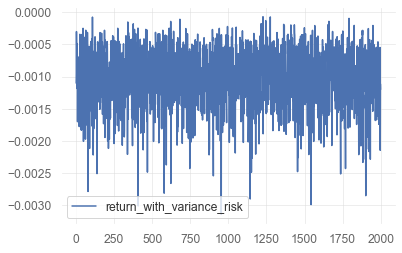

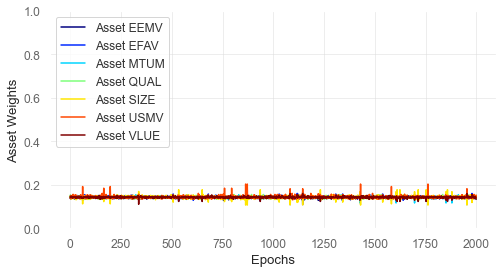

 40%|██████████████████████████████▊                                              | 4000/10000 [01:56<06:31, 15.31it/s]

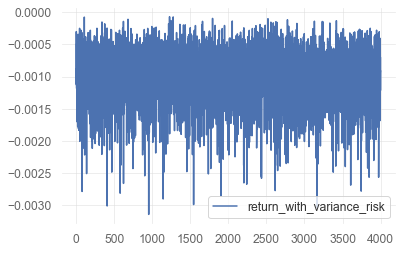

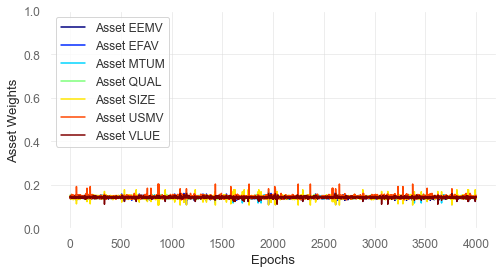

 60%|██████████████████████████████████████████████▏                              | 6000/10000 [02:53<01:09, 57.19it/s]

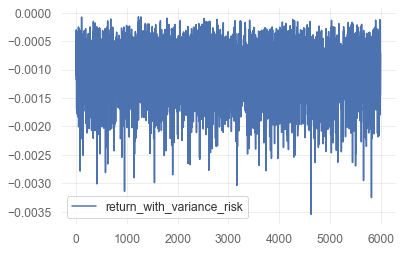

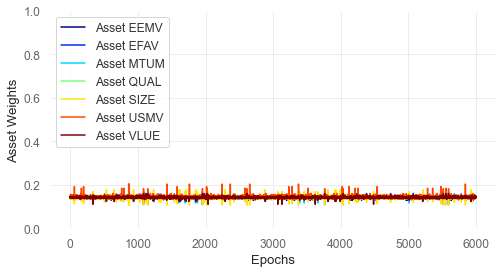

 80%|█████████████████████████████████████████████████████████████▌               | 7997/10000 [03:30<00:48, 41.49it/s]

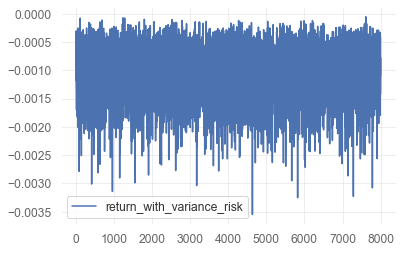

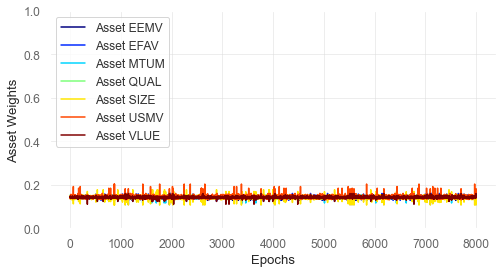

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:11<00:00, 61.70it/s]

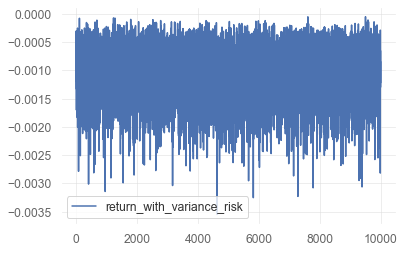

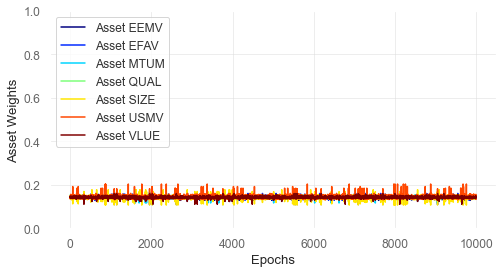

[]

In [14]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, verbose=True)

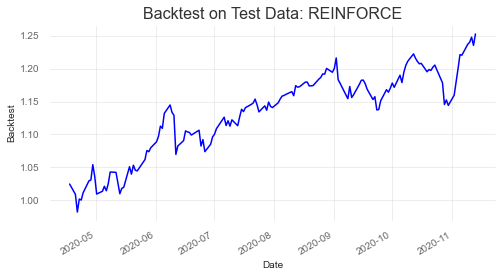

In [15]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

### REINFORCE with Baseline

covariance rolling estimate 128



pre-sampling indices:   9%|█████▎                                                    | 48/528 [00:00<00:01, 470.50it/s]


covariance rolling estimate 128


pre-sampling indices: 100%|█████████████████████████████████████████████████████████| 528/528 [00:01<00:00, 454.38it/s]

  3%|██▍                                                                           | 309/10000 [00:06<03:07, 51.62it/s]


  7%|█████▏                                                                        | 667/10000 [00:14<03:55, 39.58it/s]


 10%|███████▊                                                                     | 1018/10000 [00:21<04:09, 35.96it/s]


 12%|█████████▌                                                                   | 1234/10000 [00:30<06:34, 22.22it/s]


 15%|███████████▏                                                                 | 1458/10000 [00:38<06:39, 21.39it/s]


 17%|█████████████▍                                                               | 1748/10000 [00:46<04:03, 33.92it/s]


 20%|███████████████▏                                                             | 1978/10000 [00:56<04:32, 29.41it/s]


 20%|███████████████▎                                                             | 1995/10000 [00:56<03:33, 37.48it/s]

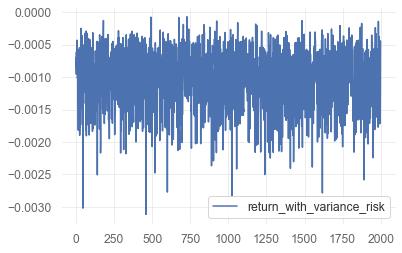

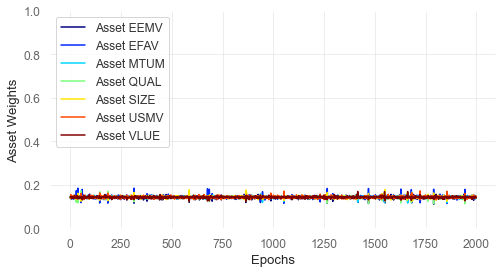


 23%|█████████████████▉                                                           | 2325/10000 [01:05<02:50, 44.92it/s]


 26%|████████████████████▎                                                        | 2631/10000 [01:13<02:29, 49.24it/s]


 30%|███████████████████████▏                                                     | 3006/10000 [01:21<02:17, 50.74it/s]


 34%|██████████████████████████                                                   | 3390/10000 [01:29<02:12, 50.00it/s]


 37%|████████████████████████████▋                                                | 3728/10000 [01:37<03:15, 32.12it/s]


 40%|██████████████████████████████▊                                              | 3997/10000 [01:43<02:00, 49.66it/s]

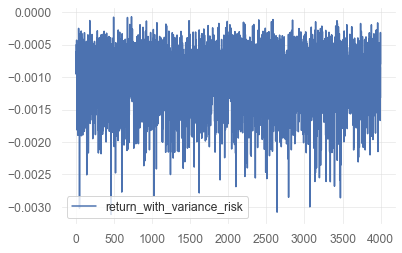

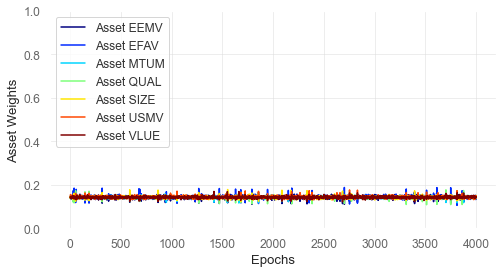


 43%|█████████████████████████████████▍                                           | 4337/10000 [01:52<02:00, 47.07it/s]


 47%|████████████████████████████████████▏                                        | 4693/10000 [02:00<01:44, 50.59it/s]


 50%|██████████████████████████████████████▊                                      | 5039/10000 [02:08<03:37, 22.77it/s]


 53%|████████████████████████████████████████▊                                    | 5295/10000 [02:17<03:02, 25.73it/s]


 54%|█████████████████████████████████████████▉                                   | 5445/10000 [02:27<03:04, 24.63it/s]


 56%|███████████████████████████████████████████▍                                 | 5646/10000 [02:37<02:26, 29.63it/s]


 59%|█████████████████████████████████████████████▍                               | 5893/10000 [02:45<01:52, 36.64it/s]


 60%|██████████████████████████████████████████████▏                              | 5998/10000 [02:48<02:08, 31.14it/s]

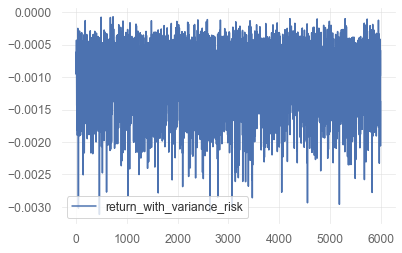

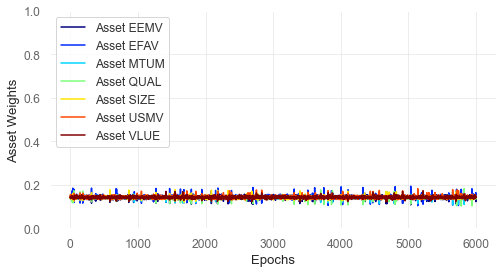


 63%|████████████████████████████████████████████████▎                            | 6272/10000 [02:57<01:38, 37.70it/s]


 65%|██████████████████████████████████████████████████▎                          | 6531/10000 [03:06<03:01, 19.14it/s]


 68%|████████████████████████████████████████████████████▏                        | 6770/10000 [03:14<01:31, 35.23it/s]


 70%|██████████████████████████████████████████████████████                       | 7015/10000 [03:23<03:03, 16.23it/s]


 71%|███████████████████████████████████████████████████████                      | 7147/10000 [03:33<04:01, 11.81it/s]


 73%|████████████████████████████████████████████████████████▏                    | 7302/10000 [03:43<02:55, 15.39it/s]


 74%|█████████████████████████████████████████████████████████▎                   | 7436/10000 [03:53<03:57, 10.81it/s]


 76%|██████████████████████████████████████████████████████████▍                  | 7584/10000 [04:02<03:56, 10.19it/s]


 78%|███████████████████████████████████████████████████████████▊                 | 7761/10000 [04:12<01:58, 18.94it/s]


 80%|█████████████████████████████████████████████████████████████▎               | 7964/10000 [04:21<00:40, 50.86it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 7999/10000 [04:22<00:43, 46.45it/s]

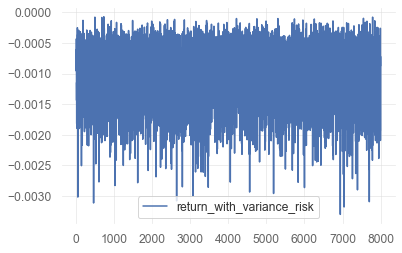

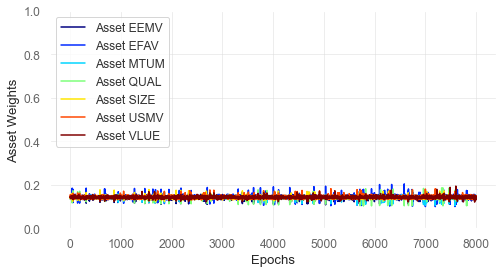


 82%|███████████████████████████████████████████████████████████████              | 8196/10000 [04:34<00:46, 38.54it/s]


 84%|█████████████████████████████████████████████████████████████████            | 8442/10000 [04:44<01:27, 17.88it/s]


 86%|██████████████████████████████████████████████████████████████████▌          | 8646/10000 [04:53<01:15, 17.94it/s]


 88%|████████████████████████████████████████████████████████████████████         | 8847/10000 [05:03<01:08, 16.86it/s]


 92%|██████████████████████████████████████████████████████████████████████▋      | 9181/10000 [05:10<00:19, 41.58it/s]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 9550/10000 [05:18<00:08, 54.53it/s]


 99%|████████████████████████████████████████████████████████████████████████████▍| 9933/10000 [05:26<00:01, 44.46it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:27<00:00, 42.48it/s]

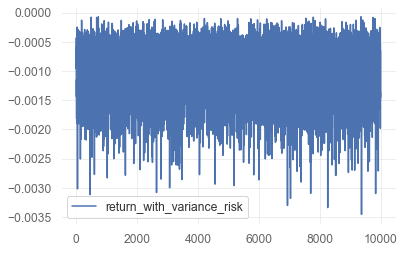

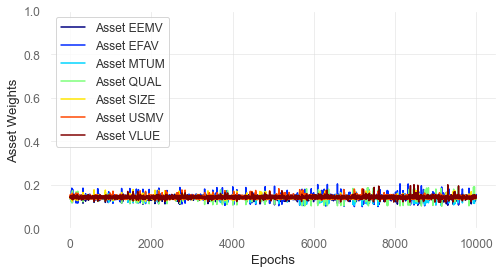

[]

In [16]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, verbose=True)

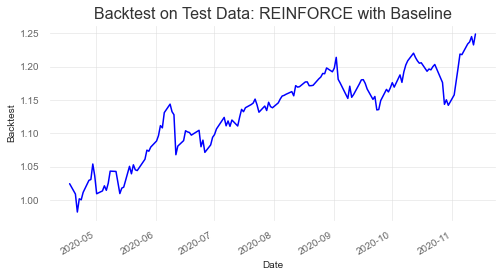

In [17]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic

covariance rolling estimate 128




pre-sampling indices:   0%|                                                                    | 0/528 [00:00<?, ?it/s]

pre-sampling indices:   8%|████▌                                                     | 41/528 [00:00<00:01, 401.84it/s]

covariance rolling estimate 128




pre-sampling indices:  13%|███████▋                                                  | 70/528 [00:00<00:01, 358.83it/s]

pre-sampling indices:  22%|████████████▍                                            | 115/528 [00:00<00:01, 381.07it/s]

pre-sampling indices:  30%|█████████████████▏                                       | 159/528 [00:00<00:00, 396.00it/s]

pre-sampling indices:  39%|██████████████████████                                   | 204/528 [00:00<00:00, 409.66it/s]

pre-sampling indices:  48%|███████████████████████████▎                             | 253/528 [00:00<00:00, 430.85it/s]

pre-sampling indices:  55%|███████████████████████████████▋                         | 293/528 [00:00<00:00, 410.73it/s]

pre-sampling indices:  64%|████████████████████████████████████▍                    | 338/528 [00:00<00:00, 420.58it/s]

pre-sampling indices:  73%|█████████████████████████████████████████▉               | 388/528 [00:00<00:00, 439.31it/s]

pre-sampling indices:  83%|███

  2%|█▌                                                                            | 207/10000 [00:07<03:30, 46.58it/s]

  2%|█▋                                                                            | 213/10000 [00:07<03:25, 47.67it/s]

  2%|█▋                                                                            | 219/10000 [00:07<03:21, 48.62it/s]

  2%|█▊                                                                            | 225/10000 [00:07<03:15, 49.90it/s]

  2%|█▊                                                                            | 231/10000 [00:08<03:22, 48.35it/s]

  2%|█▊                                                                            | 237/10000 [00:08<03:15, 49.81it/s]

  2%|█▉                                                                            | 243/10000 [00:08<03:19, 48.89it/s]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:42<00:00, 42.48it/s]

  3%|█▉                         

  5%|███▊                                                                          | 494/10000 [00:15<05:22, 29.47it/s]

  5%|███▉                                                                          | 499/10000 [00:15<04:51, 32.61it/s]

  5%|███▉                                                                          | 504/10000 [00:15<04:35, 34.41it/s]

  5%|███▉                                                                          | 509/10000 [00:15<04:19, 36.64it/s]

  5%|████                                                                          | 514/10000 [00:15<04:01, 39.27it/s]

  5%|████                                                                          | 519/10000 [00:15<03:47, 41.66it/s]

  5%|████                                                                          | 524/10000 [00:16<03:40, 43.06it/s]

  5%|████▏                                                                         | 529/10000 [00:16<03:41, 42.74it/s]

  5%|████▏                      

  8%|██████                                                                        | 782/10000 [00:23<04:46, 32.14it/s]

  8%|██████▏                                                                       | 786/10000 [00:23<05:00, 30.62it/s]

  8%|██████▏                                                                       | 790/10000 [00:23<05:38, 27.22it/s]

  8%|██████▏                                                                       | 794/10000 [00:23<05:09, 29.72it/s]

  8%|██████▏                                                                       | 798/10000 [00:23<04:58, 30.84it/s]

  8%|██████▎                                                                       | 802/10000 [00:24<04:52, 31.45it/s]

  8%|██████▎                                                                       | 806/10000 [00:24<04:48, 31.92it/s]

  8%|██████▎                                                                       | 810/10000 [00:24<04:50, 31.64it/s]

  8%|██████▎                    

 10%|███████▉                                                                     | 1030/10000 [00:31<04:37, 32.37it/s]

 10%|███████▉                                                                     | 1034/10000 [00:31<04:24, 33.90it/s]

 10%|███████▉                                                                     | 1038/10000 [00:31<04:16, 34.97it/s]

 10%|████████                                                                     | 1042/10000 [00:31<04:36, 32.37it/s]

 10%|████████                                                                     | 1046/10000 [00:31<04:23, 33.98it/s]

 10%|████████                                                                     | 1050/10000 [00:32<04:57, 30.05it/s]

 11%|████████                                                                     | 1054/10000 [00:32<05:03, 29.46it/s]

 11%|████████▏                                                                    | 1058/10000 [00:32<04:47, 31.10it/s]

 11%|████████▏                  

 13%|█████████▊                                                                   | 1281/10000 [00:39<05:42, 25.49it/s]

 13%|█████████▉                                                                   | 1284/10000 [00:39<07:06, 20.43it/s]

 13%|█████████▉                                                                   | 1287/10000 [00:40<08:05, 17.96it/s]

 13%|█████████▉                                                                   | 1290/10000 [00:40<08:10, 17.77it/s]

 13%|█████████▉                                                                   | 1292/10000 [00:40<08:06, 17.89it/s]

 13%|█████████▉                                                                   | 1295/10000 [00:40<07:33, 19.19it/s]

 13%|█████████▉                                                                   | 1298/10000 [00:40<06:48, 21.28it/s]

 13%|██████████                                                                   | 1301/10000 [00:40<06:27, 22.43it/s]

 13%|██████████                 

 15%|███████████▌                                                                 | 1505/10000 [00:48<05:24, 26.14it/s]

 15%|███████████▌                                                                 | 1509/10000 [00:48<04:56, 28.67it/s]

 15%|███████████▋                                                                 | 1514/10000 [00:48<04:33, 30.98it/s]

 15%|███████████▋                                                                 | 1518/10000 [00:48<04:22, 32.27it/s]

 15%|███████████▋                                                                 | 1522/10000 [00:48<04:13, 33.40it/s]

 15%|███████████▊                                                                 | 1526/10000 [00:48<04:18, 32.72it/s]

 15%|███████████▊                                                                 | 1531/10000 [00:48<04:03, 34.83it/s]

 15%|███████████▊                                                                 | 1535/10000 [00:48<04:01, 35.00it/s]

 15%|███████████▊               

 18%|█████████████▌                                                               | 1764/10000 [00:55<03:56, 34.82it/s]

 18%|█████████████▌                                                               | 1768/10000 [00:55<03:52, 35.46it/s]

 18%|█████████████▋                                                               | 1772/10000 [00:56<03:52, 35.34it/s]

 18%|█████████████▋                                                               | 1776/10000 [00:56<03:45, 36.52it/s]

 18%|█████████████▋                                                               | 1780/10000 [00:56<03:55, 34.85it/s]

 18%|█████████████▋                                                               | 1784/10000 [00:56<03:54, 35.02it/s]

 18%|█████████████▊                                                               | 1788/10000 [00:56<03:59, 34.23it/s]

 18%|█████████████▊                                                               | 1792/10000 [00:56<04:17, 31.85it/s]

 18%|█████████████▊             

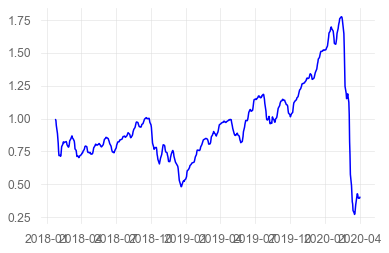

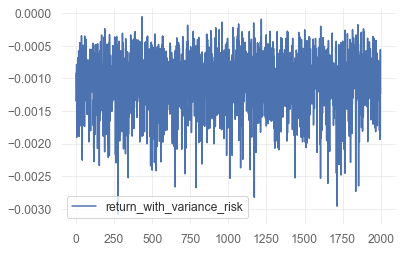

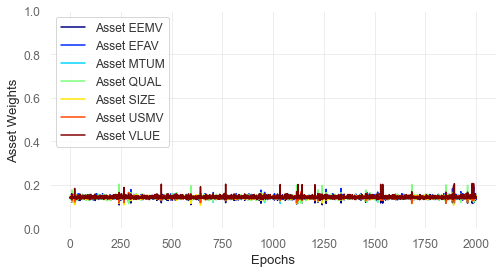

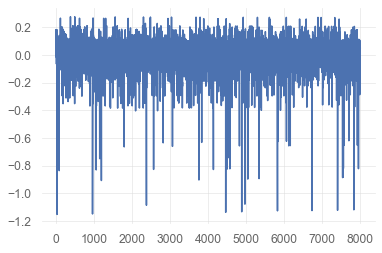



 20%|███████████████▍                                                             | 2004/10000 [01:05<24:47,  5.38it/s]

 20%|███████████████▍                                                             | 2008/10000 [01:05<18:24,  7.24it/s]

 20%|███████████████▍                                                             | 2011/10000 [01:05<14:26,  9.22it/s]

 20%|███████████████▌                                                             | 2014/10000 [01:05<11:52, 11.21it/s]

 20%|███████████████▌                                                             | 2018/10000 [01:05<09:34, 13.90it/s]

 20%|███████████████▌                                                             | 2022/10000 [01:06<07:46, 17.10it/s]

 20%|███████████████▌                                                             | 2026/10000 [01:06<06:41, 19.88it/s]

 20%|███████████████▋                                                             | 2030/10000 [01:06<05:47, 22.93it/s]

 20%|███████████████▋         

 23%|█████████████████▍                                                           | 2259/10000 [01:13<03:48, 33.84it/s]

 23%|█████████████████▍                                                           | 2263/10000 [01:13<03:46, 34.20it/s]

 23%|█████████████████▍                                                           | 2267/10000 [01:13<03:45, 34.29it/s]

 23%|█████████████████▍                                                           | 2271/10000 [01:13<03:43, 34.52it/s]

 23%|█████████████████▌                                                           | 2275/10000 [01:13<03:48, 33.76it/s]

 23%|█████████████████▌                                                           | 2279/10000 [01:13<03:48, 33.78it/s]

 23%|█████████████████▌                                                           | 2283/10000 [01:13<03:41, 34.81it/s]

 23%|█████████████████▌                                                           | 2287/10000 [01:13<03:50, 33.46it/s]

 23%|█████████████████▋         

 25%|███████████████████▍                                                         | 2517/10000 [01:20<04:10, 29.84it/s]

 25%|███████████████████▍                                                         | 2521/10000 [01:21<04:04, 30.60it/s]

 25%|███████████████████▍                                                         | 2525/10000 [01:21<03:56, 31.59it/s]

 25%|███████████████████▍                                                         | 2530/10000 [01:21<03:39, 34.06it/s]

 25%|███████████████████▌                                                         | 2534/10000 [01:21<04:04, 30.58it/s]

 25%|███████████████████▌                                                         | 2538/10000 [01:21<04:06, 30.22it/s]

 25%|███████████████████▌                                                         | 2542/10000 [01:21<04:12, 29.51it/s]

 25%|███████████████████▌                                                         | 2546/10000 [01:21<04:05, 30.35it/s]

 26%|███████████████████▋       

 28%|█████████████████████▏                                                       | 2758/10000 [01:28<04:09, 29.03it/s]

 28%|█████████████████████▎                                                       | 2762/10000 [01:29<04:00, 30.06it/s]

 28%|█████████████████████▎                                                       | 2766/10000 [01:29<03:58, 30.34it/s]

 28%|█████████████████████▎                                                       | 2770/10000 [01:29<04:13, 28.57it/s]

 28%|█████████████████████▎                                                       | 2773/10000 [01:29<04:15, 28.33it/s]

 28%|█████████████████████▍                                                       | 2776/10000 [01:29<04:15, 28.24it/s]

 28%|█████████████████████▍                                                       | 2780/10000 [01:29<04:06, 29.27it/s]

 28%|█████████████████████▍                                                       | 2784/10000 [01:29<03:46, 31.83it/s]

 28%|█████████████████████▍     

 30%|██████████████████████▉                                                      | 2983/10000 [01:37<09:21, 12.50it/s]

 30%|██████████████████████▉                                                      | 2985/10000 [01:37<09:27, 12.36it/s]

 30%|██████████████████████▉                                                      | 2987/10000 [01:37<08:52, 13.16it/s]

 30%|███████████████████████                                                      | 2989/10000 [01:37<09:26, 12.38it/s]

 30%|███████████████████████                                                      | 2991/10000 [01:37<08:24, 13.89it/s]

 30%|███████████████████████                                                      | 2994/10000 [01:38<07:28, 15.62it/s]

 30%|███████████████████████                                                      | 2997/10000 [01:38<06:27, 18.08it/s]

 30%|███████████████████████                                                      | 3000/10000 [01:38<05:57, 19.60it/s]

 30%|███████████████████████    

 32%|████████████████████████▌                                                    | 3183/10000 [01:45<06:04, 18.69it/s]

 32%|████████████████████████▌                                                    | 3186/10000 [01:46<05:33, 20.43it/s]

 32%|████████████████████████▌                                                    | 3189/10000 [01:46<05:05, 22.29it/s]

 32%|████████████████████████▌                                                    | 3192/10000 [01:46<04:50, 23.47it/s]

 32%|████████████████████████▌                                                    | 3195/10000 [01:46<04:54, 23.08it/s]

 32%|████████████████████████▌                                                    | 3198/10000 [01:46<04:35, 24.67it/s]

 32%|████████████████████████▋                                                    | 3202/10000 [01:46<04:12, 26.90it/s]

 32%|████████████████████████▋                                                    | 3205/10000 [01:46<04:10, 27.16it/s]

 32%|████████████████████████▋  

 34%|██████████████████████████                                                   | 3383/10000 [01:54<04:54, 22.47it/s]

 34%|██████████████████████████                                                   | 3386/10000 [01:54<04:51, 22.69it/s]

 34%|██████████████████████████                                                   | 3389/10000 [01:54<04:40, 23.56it/s]

 34%|██████████████████████████                                                   | 3392/10000 [01:54<04:43, 23.34it/s]

 34%|██████████████████████████▏                                                  | 3395/10000 [01:54<04:50, 22.77it/s]

 34%|██████████████████████████▏                                                  | 3398/10000 [01:55<04:57, 22.16it/s]

 34%|██████████████████████████▏                                                  | 3401/10000 [01:55<04:40, 23.54it/s]

 34%|██████████████████████████▏                                                  | 3405/10000 [01:55<04:20, 25.32it/s]

 34%|██████████████████████████▏

 36%|███████████████████████████▌                                                 | 3585/10000 [02:02<03:34, 29.86it/s]

 36%|███████████████████████████▋                                                 | 3589/10000 [02:02<03:54, 27.35it/s]

 36%|███████████████████████████▋                                                 | 3592/10000 [02:03<04:18, 24.82it/s]

 36%|███████████████████████████▋                                                 | 3595/10000 [02:03<04:14, 25.21it/s]

 36%|███████████████████████████▋                                                 | 3598/10000 [02:03<05:12, 20.48it/s]

 36%|███████████████████████████▋                                                 | 3601/10000 [02:03<04:59, 21.40it/s]

 36%|███████████████████████████▊                                                 | 3604/10000 [02:03<04:46, 22.32it/s]

 36%|███████████████████████████▊                                                 | 3607/10000 [02:03<04:38, 22.92it/s]

 36%|███████████████████████████

 38%|█████████████████████████████▏                                               | 3787/10000 [02:10<03:50, 26.94it/s]

 38%|█████████████████████████████▏                                               | 3791/10000 [02:10<03:37, 28.57it/s]

 38%|█████████████████████████████▏                                               | 3795/10000 [02:11<03:32, 29.21it/s]

 38%|█████████████████████████████▏                                               | 3798/10000 [02:11<03:33, 29.02it/s]

 38%|█████████████████████████████▎                                               | 3801/10000 [02:11<03:34, 28.85it/s]

 38%|█████████████████████████████▎                                               | 3805/10000 [02:11<03:25, 30.09it/s]

 38%|█████████████████████████████▎                                               | 3809/10000 [02:11<03:22, 30.62it/s]

 38%|█████████████████████████████▎                                               | 3813/10000 [02:11<03:19, 31.03it/s]

 38%|███████████████████████████

 40%|██████████████████████████████▋                                              | 3993/10000 [02:19<04:02, 24.75it/s]

 40%|██████████████████████████████▊                                              | 3997/10000 [02:19<03:46, 26.51it/s]

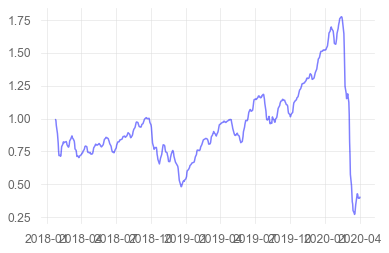

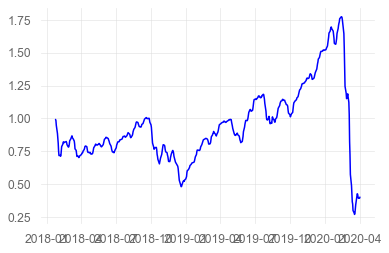

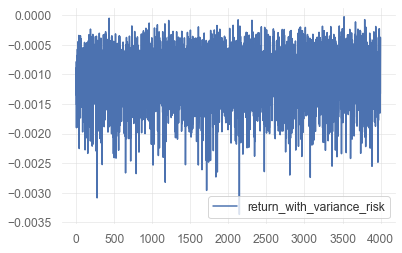

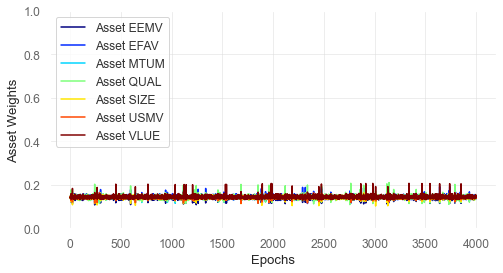

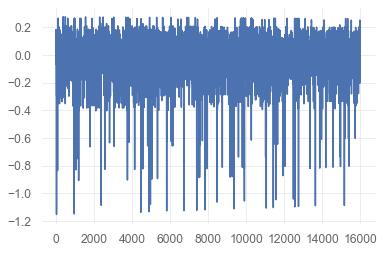



 40%|██████████████████████████████▊                                              | 4001/10000 [02:22<24:30,  4.08it/s]

 40%|██████████████████████████████▊                                              | 4004/10000 [02:22<18:09,  5.50it/s]

 40%|██████████████████████████████▊                                              | 4007/10000 [02:22<13:54,  7.18it/s]

 40%|██████████████████████████████▉                                              | 4010/10000 [02:22<10:47,  9.26it/s]

 40%|██████████████████████████████▉                                              | 4014/10000 [02:22<08:28, 11.76it/s]

 40%|██████████████████████████████▉                                              | 4017/10000 [02:22<06:57, 14.33it/s]

 40%|██████████████████████████████▉                                              | 4021/10000 [02:22<05:45, 17.29it/s]

 40%|██████████████████████████████▉                                              | 4025/10000 [02:22<04:51, 20.51it/s]

 40%|█████████████████████████

 42%|████████████████████████████████▍                                            | 4209/10000 [02:30<04:42, 20.50it/s]

 42%|████████████████████████████████▍                                            | 4212/10000 [02:30<04:36, 20.94it/s]

 42%|████████████████████████████████▍                                            | 4215/10000 [02:30<04:39, 20.69it/s]

 42%|████████████████████████████████▍                                            | 4218/10000 [02:30<04:39, 20.69it/s]

 42%|████████████████████████████████▌                                            | 4221/10000 [02:30<04:29, 21.45it/s]

 42%|████████████████████████████████▌                                            | 4224/10000 [02:31<04:22, 22.01it/s]

 42%|████████████████████████████████▌                                            | 4227/10000 [02:31<04:16, 22.47it/s]

 42%|████████████████████████████████▌                                            | 4230/10000 [02:31<04:34, 21.01it/s]

 42%|███████████████████████████

 44%|█████████████████████████████████▋                                           | 4373/10000 [02:38<03:54, 23.95it/s]

 44%|█████████████████████████████████▋                                           | 4376/10000 [02:38<03:57, 23.68it/s]

 44%|█████████████████████████████████▋                                           | 4380/10000 [02:39<03:36, 25.94it/s]

 44%|█████████████████████████████████▋                                           | 4383/10000 [02:39<03:30, 26.69it/s]

 44%|█████████████████████████████████▊                                           | 4386/10000 [02:39<03:26, 27.23it/s]

 44%|█████████████████████████████████▊                                           | 4389/10000 [02:39<03:23, 27.61it/s]

 44%|█████████████████████████████████▊                                           | 4392/10000 [02:39<03:23, 27.49it/s]

 44%|█████████████████████████████████▊                                           | 4395/10000 [02:39<03:24, 27.43it/s]

 44%|███████████████████████████

 46%|███████████████████████████████████▍                                         | 4601/10000 [02:46<02:37, 34.19it/s]

 46%|███████████████████████████████████▍                                         | 4605/10000 [02:46<02:40, 33.53it/s]

 46%|███████████████████████████████████▍                                         | 4609/10000 [02:47<02:38, 33.98it/s]

 46%|███████████████████████████████████▌                                         | 4613/10000 [02:47<02:47, 32.16it/s]

 46%|███████████████████████████████████▌                                         | 4617/10000 [02:47<02:46, 32.26it/s]

 46%|███████████████████████████████████▌                                         | 4621/10000 [02:47<02:41, 33.31it/s]

 46%|███████████████████████████████████▌                                         | 4625/10000 [02:47<02:34, 34.71it/s]

 46%|███████████████████████████████████▋                                         | 4629/10000 [02:47<02:29, 35.85it/s]

 46%|███████████████████████████

 48%|████████████████████████████████████▊                                        | 4783/10000 [02:55<05:14, 16.58it/s]

 48%|████████████████████████████████████▊                                        | 4785/10000 [02:55<05:23, 16.11it/s]

 48%|████████████████████████████████████▊                                        | 4787/10000 [02:55<05:20, 16.27it/s]

 48%|████████████████████████████████████▉                                        | 4790/10000 [02:55<04:51, 17.88it/s]

 48%|████████████████████████████████████▉                                        | 4793/10000 [02:56<04:35, 18.93it/s]

 48%|████████████████████████████████████▉                                        | 4796/10000 [02:56<04:14, 20.42it/s]

 48%|████████████████████████████████████▉                                        | 4799/10000 [02:56<04:16, 20.30it/s]

 48%|████████████████████████████████████▉                                        | 4802/10000 [02:56<03:59, 21.70it/s]

 48%|███████████████████████████

 50%|██████████████████████████████████████▎                                      | 4971/10000 [03:03<03:32, 23.70it/s]

 50%|██████████████████████████████████████▎                                      | 4974/10000 [03:03<03:34, 23.39it/s]

 50%|██████████████████████████████████████▎                                      | 4977/10000 [03:04<03:28, 24.14it/s]

 50%|██████████████████████████████████████▎                                      | 4980/10000 [03:04<04:13, 19.80it/s]

 50%|██████████████████████████████████████▎                                      | 4983/10000 [03:04<04:06, 20.39it/s]

 50%|██████████████████████████████████████▍                                      | 4986/10000 [03:04<04:12, 19.87it/s]

 50%|██████████████████████████████████████▍                                      | 4989/10000 [03:04<04:10, 20.03it/s]

 50%|██████████████████████████████████████▍                                      | 4992/10000 [03:04<03:51, 21.62it/s]

 50%|███████████████████████████

 52%|████████████████████████████████████████▏                                    | 5218/10000 [03:11<02:16, 35.09it/s]

 52%|████████████████████████████████████████▏                                    | 5222/10000 [03:11<02:13, 35.75it/s]

 52%|████████████████████████████████████████▏                                    | 5226/10000 [03:11<02:10, 36.52it/s]

 52%|████████████████████████████████████████▎                                    | 5230/10000 [03:11<02:13, 35.60it/s]

 52%|████████████████████████████████████████▎                                    | 5234/10000 [03:11<02:13, 35.82it/s]

 52%|████████████████████████████████████████▎                                    | 5238/10000 [03:12<02:15, 35.22it/s]

 52%|████████████████████████████████████████▎                                    | 5242/10000 [03:12<02:14, 35.37it/s]

 52%|████████████████████████████████████████▍                                    | 5246/10000 [03:12<02:14, 35.38it/s]

 52%|███████████████████████████

 55%|██████████████████████████████████████████▏                                  | 5478/10000 [03:19<02:17, 32.88it/s]

 55%|██████████████████████████████████████████▏                                  | 5482/10000 [03:19<02:13, 33.94it/s]

 55%|██████████████████████████████████████████▏                                  | 5486/10000 [03:19<02:07, 35.46it/s]

 55%|██████████████████████████████████████████▎                                  | 5490/10000 [03:19<02:14, 33.48it/s]

 55%|██████████████████████████████████████████▎                                  | 5494/10000 [03:19<02:19, 32.38it/s]

 55%|██████████████████████████████████████████▎                                  | 5498/10000 [03:19<02:25, 30.84it/s]

 55%|██████████████████████████████████████████▎                                  | 5502/10000 [03:19<02:34, 29.07it/s]

 55%|██████████████████████████████████████████▍                                  | 5505/10000 [03:20<02:47, 26.90it/s]

 55%|███████████████████████████

 57%|███████████████████████████████████████████▉                                 | 5712/10000 [03:27<03:24, 20.99it/s]

 57%|████████████████████████████████████████████                                 | 5715/10000 [03:27<03:23, 21.07it/s]

 57%|████████████████████████████████████████████                                 | 5718/10000 [03:27<03:26, 20.74it/s]

 57%|████████████████████████████████████████████                                 | 5721/10000 [03:27<03:28, 20.51it/s]

 57%|████████████████████████████████████████████                                 | 5724/10000 [03:28<03:45, 19.00it/s]

 57%|████████████████████████████████████████████                                 | 5726/10000 [03:28<04:07, 17.24it/s]

 57%|████████████████████████████████████████████                                 | 5728/10000 [03:28<03:57, 17.99it/s]

 57%|████████████████████████████████████████████▏                                | 5731/10000 [03:28<03:44, 19.01it/s]

 57%|███████████████████████████

 59%|█████████████████████████████████████████████▍                               | 5905/10000 [03:35<02:20, 29.12it/s]

 59%|█████████████████████████████████████████████▍                               | 5908/10000 [03:35<02:25, 28.22it/s]

 59%|█████████████████████████████████████████████▌                               | 5912/10000 [03:35<02:15, 30.25it/s]

 59%|█████████████████████████████████████████████▌                               | 5916/10000 [03:36<02:05, 32.48it/s]

 59%|█████████████████████████████████████████████▌                               | 5920/10000 [03:36<02:10, 31.35it/s]

 59%|█████████████████████████████████████████████▌                               | 5924/10000 [03:36<02:44, 24.79it/s]

 59%|█████████████████████████████████████████████▋                               | 5927/10000 [03:36<02:40, 25.42it/s]

 59%|█████████████████████████████████████████████▋                               | 5930/10000 [03:36<02:51, 23.68it/s]

 59%|███████████████████████████

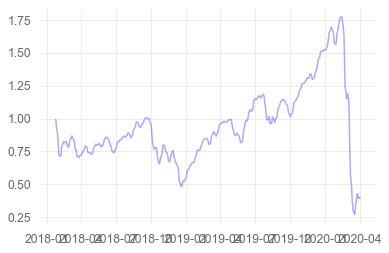

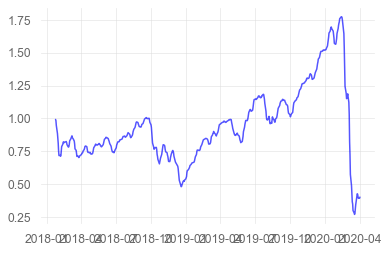

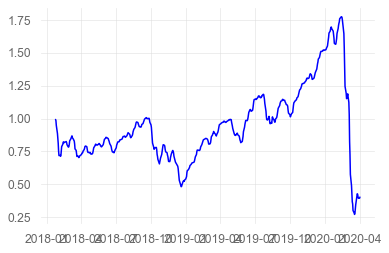

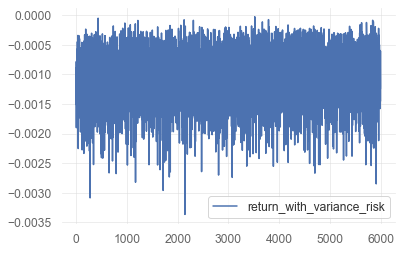

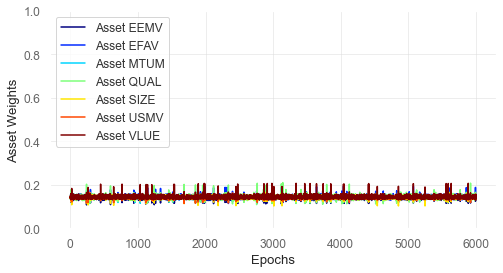

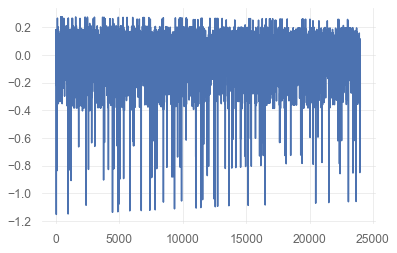



 60%|██████████████████████████████████████████████▏                              | 6002/10000 [03:42<19:19,  3.45it/s]

 60%|██████████████████████████████████████████████▏                              | 6006/10000 [03:42<14:03,  4.74it/s]

 60%|██████████████████████████████████████████████▎                              | 6010/10000 [03:42<10:23,  6.40it/s]

 60%|██████████████████████████████████████████████▎                              | 6014/10000 [03:42<07:52,  8.44it/s]

 60%|██████████████████████████████████████████████▎                              | 6018/10000 [03:42<06:03, 10.94it/s]

 60%|██████████████████████████████████████████████▎                              | 6022/10000 [03:42<04:49, 13.72it/s]

 60%|██████████████████████████████████████████████▍                              | 6026/10000 [03:42<03:56, 16.79it/s]

 60%|██████████████████████████████████████████████▍                              | 6030/10000 [03:43<03:27, 19.16it/s]

 60%|█████████████████████████

 63%|████████████████████████████████████████████████▏                            | 6260/10000 [03:50<02:10, 28.73it/s]

 63%|████████████████████████████████████████████████▏                            | 6264/10000 [03:50<02:01, 30.73it/s]

 63%|████████████████████████████████████████████████▎                            | 6268/10000 [03:50<01:54, 32.54it/s]

 63%|████████████████████████████████████████████████▎                            | 6273/10000 [03:50<01:47, 34.76it/s]

 63%|████████████████████████████████████████████████▎                            | 6277/10000 [03:50<01:48, 34.41it/s]

 63%|████████████████████████████████████████████████▎                            | 6281/10000 [03:50<01:53, 32.74it/s]

 63%|████████████████████████████████████████████████▍                            | 6285/10000 [03:50<02:01, 30.56it/s]

 63%|████████████████████████████████████████████████▍                            | 6289/10000 [03:51<02:30, 24.58it/s]

 63%|███████████████████████████

 65%|██████████████████████████████████████████████████▏                          | 6513/10000 [03:57<01:43, 33.62it/s]

 65%|██████████████████████████████████████████████████▏                          | 6517/10000 [03:58<01:49, 31.93it/s]

 65%|██████████████████████████████████████████████████▏                          | 6521/10000 [03:58<01:47, 32.36it/s]

 65%|██████████████████████████████████████████████████▏                          | 6525/10000 [03:58<01:43, 33.44it/s]

 65%|██████████████████████████████████████████████████▎                          | 6529/10000 [03:58<01:38, 35.16it/s]

 65%|██████████████████████████████████████████████████▎                          | 6533/10000 [03:58<01:38, 35.06it/s]

 65%|██████████████████████████████████████████████████▎                          | 6537/10000 [03:58<01:39, 34.97it/s]

 65%|██████████████████████████████████████████████████▎                          | 6541/10000 [03:58<01:42, 33.59it/s]

 65%|███████████████████████████

 68%|████████████████████████████████████████████████████                         | 6766/10000 [04:05<01:33, 34.53it/s]

 68%|████████████████████████████████████████████████████▏                        | 6770/10000 [04:05<01:30, 35.72it/s]

 68%|████████████████████████████████████████████████████▏                        | 6774/10000 [04:05<01:31, 35.36it/s]

 68%|████████████████████████████████████████████████████▏                        | 6778/10000 [04:05<01:29, 36.09it/s]

 68%|████████████████████████████████████████████████████▏                        | 6782/10000 [04:06<01:27, 36.57it/s]

 68%|████████████████████████████████████████████████████▎                        | 6786/10000 [04:06<01:28, 36.21it/s]

 68%|████████████████████████████████████████████████████▎                        | 6790/10000 [04:06<01:30, 35.30it/s]

 68%|████████████████████████████████████████████████████▎                        | 6794/10000 [04:06<01:30, 35.23it/s]

 68%|███████████████████████████

 70%|█████████████████████████████████████████████████████▉                       | 7006/10000 [04:13<02:12, 22.67it/s]

 70%|█████████████████████████████████████████████████████▉                       | 7009/10000 [04:13<02:09, 23.11it/s]

 70%|█████████████████████████████████████████████████████▉                       | 7012/10000 [04:13<02:04, 23.99it/s]

 70%|██████████████████████████████████████████████████████                       | 7015/10000 [04:13<02:00, 24.82it/s]

 70%|██████████████████████████████████████████████████████                       | 7018/10000 [04:13<01:55, 25.77it/s]

 70%|██████████████████████████████████████████████████████                       | 7021/10000 [04:14<01:52, 26.48it/s]

 70%|██████████████████████████████████████████████████████                       | 7024/10000 [04:14<02:00, 24.61it/s]

 70%|██████████████████████████████████████████████████████                       | 7027/10000 [04:14<02:04, 23.84it/s]

 70%|███████████████████████████

 72%|███████████████████████████████████████████████████████▎                     | 7176/10000 [04:22<01:40, 28.18it/s]

 72%|███████████████████████████████████████████████████████▎                     | 7180/10000 [04:22<01:36, 29.22it/s]

 72%|███████████████████████████████████████████████████████▎                     | 7185/10000 [04:22<01:27, 32.29it/s]

 72%|███████████████████████████████████████████████████████▎                     | 7190/10000 [04:22<01:20, 34.69it/s]

 72%|███████████████████████████████████████████████████████▍                     | 7194/10000 [04:22<01:22, 34.10it/s]

 72%|███████████████████████████████████████████████████████▍                     | 7198/10000 [04:22<01:21, 34.48it/s]

 72%|███████████████████████████████████████████████████████▍                     | 7202/10000 [04:22<01:24, 32.95it/s]

 72%|███████████████████████████████████████████████████████▍                     | 7206/10000 [04:23<01:30, 30.84it/s]

 72%|███████████████████████████

 74%|█████████████████████████████████████████████████████████                    | 7407/10000 [04:30<01:27, 29.70it/s]

 74%|█████████████████████████████████████████████████████████                    | 7411/10000 [04:30<01:26, 29.81it/s]

 74%|█████████████████████████████████████████████████████████                    | 7415/10000 [04:30<01:29, 29.04it/s]

 74%|█████████████████████████████████████████████████████████▏                   | 7419/10000 [04:30<01:26, 29.87it/s]

 74%|█████████████████████████████████████████████████████████▏                   | 7423/10000 [04:31<01:24, 30.41it/s]

 74%|█████████████████████████████████████████████████████████▏                   | 7427/10000 [04:31<01:26, 29.63it/s]

 74%|█████████████████████████████████████████████████████████▏                   | 7430/10000 [04:31<01:28, 28.97it/s]

 74%|█████████████████████████████████████████████████████████▏                   | 7434/10000 [04:31<01:22, 30.99it/s]

 74%|███████████████████████████

 76%|██████████████████████████████████████████████████████████▉                  | 7648/10000 [04:38<01:12, 32.32it/s]

 77%|██████████████████████████████████████████████████████████▉                  | 7652/10000 [04:38<01:12, 32.20it/s]

 77%|██████████████████████████████████████████████████████████▉                  | 7656/10000 [04:38<01:12, 32.46it/s]

 77%|██████████████████████████████████████████████████████████▉                  | 7660/10000 [04:38<01:09, 33.62it/s]

 77%|███████████████████████████████████████████████████████████                  | 7664/10000 [04:38<01:10, 33.37it/s]

 77%|███████████████████████████████████████████████████████████                  | 7668/10000 [04:39<01:08, 34.04it/s]

 77%|███████████████████████████████████████████████████████████                  | 7672/10000 [04:39<01:08, 33.91it/s]

 77%|███████████████████████████████████████████████████████████                  | 7676/10000 [04:39<01:08, 33.73it/s]

 77%|███████████████████████████

 79%|████████████████████████████████████████████████████████████▊                | 7903/10000 [04:46<00:59, 35.14it/s]

 79%|████████████████████████████████████████████████████████████▉                | 7907/10000 [04:46<00:58, 35.88it/s]

 79%|████████████████████████████████████████████████████████████▉                | 7912/10000 [04:46<00:55, 37.48it/s]

 79%|████████████████████████████████████████████████████████████▉                | 7916/10000 [04:46<00:55, 37.45it/s]

 79%|████████████████████████████████████████████████████████████▉                | 7920/10000 [04:46<00:55, 37.33it/s]

 79%|█████████████████████████████████████████████████████████████                | 7924/10000 [04:46<00:56, 36.53it/s]

 79%|█████████████████████████████████████████████████████████████                | 7928/10000 [04:46<00:58, 35.32it/s]

 79%|█████████████████████████████████████████████████████████████                | 7932/10000 [04:46<00:59, 34.79it/s]

 79%|███████████████████████████

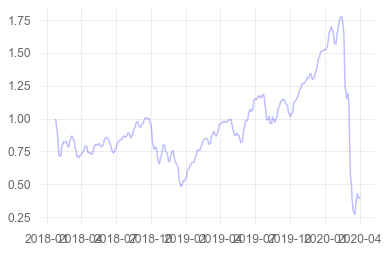

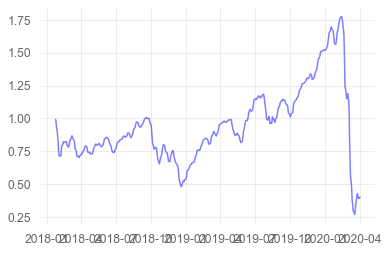

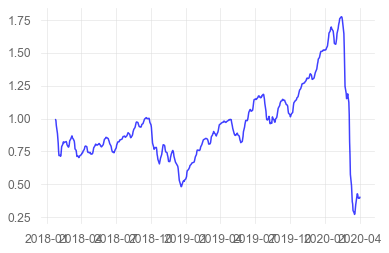

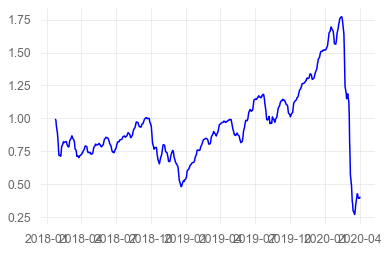

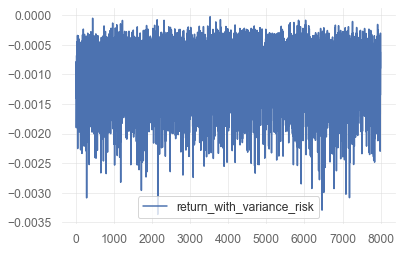

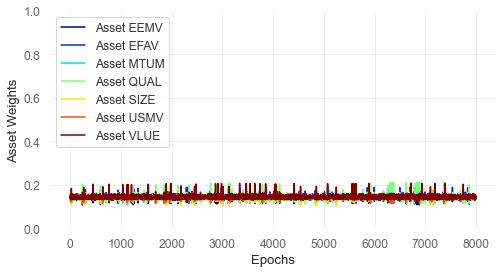

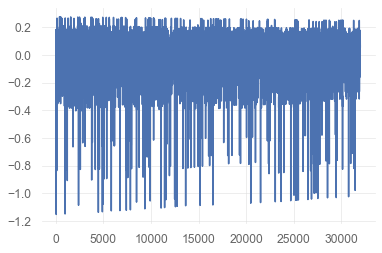



 80%|█████████████████████████████████████████████████████████████▋               | 8004/10000 [04:53<10:59,  3.03it/s]

 80%|█████████████████████████████████████████████████████████████▋               | 8008/10000 [04:53<07:58,  4.17it/s]

 80%|█████████████████████████████████████████████████████████████▋               | 8012/10000 [04:53<05:51,  5.66it/s]

 80%|█████████████████████████████████████████████████████████████▋               | 8016/10000 [04:53<04:23,  7.54it/s]

 80%|█████████████████████████████████████████████████████████████▊               | 8020/10000 [04:53<03:19,  9.93it/s]

 80%|█████████████████████████████████████████████████████████████▊               | 8024/10000 [04:53<02:37, 12.52it/s]

 80%|█████████████████████████████████████████████████████████████▊               | 8028/10000 [04:53<02:07, 15.50it/s]

 80%|█████████████████████████████████████████████████████████████▊               | 8032/10000 [04:53<01:43, 18.96it/s]

 80%|█████████████████████████

 82%|███████████████████████████████████████████████████████████████▍             | 8243/10000 [05:01<00:57, 30.55it/s]

 82%|███████████████████████████████████████████████████████████████▌             | 8247/10000 [05:01<00:53, 32.72it/s]

 83%|███████████████████████████████████████████████████████████████▌             | 8251/10000 [05:01<00:53, 32.66it/s]

 83%|███████████████████████████████████████████████████████████████▌             | 8255/10000 [05:01<00:52, 33.02it/s]

 83%|███████████████████████████████████████████████████████████████▌             | 8259/10000 [05:01<00:53, 32.39it/s]

 83%|███████████████████████████████████████████████████████████████▋             | 8263/10000 [05:01<00:50, 34.26it/s]

 83%|███████████████████████████████████████████████████████████████▋             | 8267/10000 [05:01<00:49, 34.96it/s]

 83%|███████████████████████████████████████████████████████████████▋             | 8271/10000 [05:02<00:47, 36.04it/s]

 83%|███████████████████████████

 85%|█████████████████████████████████████████████████████████████████▍           | 8501/10000 [05:09<00:54, 27.70it/s]

 85%|█████████████████████████████████████████████████████████████████▍           | 8504/10000 [05:09<00:52, 28.34it/s]

 85%|█████████████████████████████████████████████████████████████████▌           | 8508/10000 [05:09<00:50, 29.82it/s]

 85%|█████████████████████████████████████████████████████████████████▌           | 8512/10000 [05:09<00:48, 30.66it/s]

 85%|█████████████████████████████████████████████████████████████████▌           | 8516/10000 [05:09<00:48, 30.69it/s]

 85%|█████████████████████████████████████████████████████████████████▌           | 8520/10000 [05:09<00:46, 31.74it/s]

 85%|█████████████████████████████████████████████████████████████████▋           | 8524/10000 [05:09<00:47, 31.15it/s]

 85%|█████████████████████████████████████████████████████████████████▋           | 8528/10000 [05:10<00:46, 31.85it/s]

 85%|███████████████████████████

 87%|███████████████████████████████████████████████████████████████████▎         | 8736/10000 [05:17<01:23, 15.14it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8738/10000 [05:17<01:20, 15.75it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8740/10000 [05:17<01:22, 15.28it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8742/10000 [05:17<01:39, 12.70it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8744/10000 [05:18<01:30, 13.84it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8746/10000 [05:18<01:31, 13.77it/s]

 87%|███████████████████████████████████████████████████████████████████▎         | 8748/10000 [05:18<01:41, 12.39it/s]

 88%|███████████████████████████████████████████████████████████████████▍         | 8750/10000 [05:18<01:40, 12.47it/s]

 88%|███████████████████████████

 89%|████████████████████████████████████████████████████████████████████▎        | 8867/10000 [05:26<01:45, 10.74it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8869/10000 [05:26<01:36, 11.75it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8871/10000 [05:26<01:29, 12.67it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8873/10000 [05:26<01:29, 12.55it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8875/10000 [05:27<01:32, 12.21it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8877/10000 [05:27<01:33, 12.01it/s]

 89%|████████████████████████████████████████████████████████████████████▎        | 8879/10000 [05:27<01:35, 11.68it/s]

 89%|████████████████████████████████████████████████████████████████████▍        | 8881/10000 [05:27<01:32, 12.05it/s]

 89%|███████████████████████████

 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [05:36<01:40,  9.90it/s]

 90%|█████████████████████████████████████████████████████████████████████▎       | 9003/10000 [05:37<01:36, 10.28it/s]

 90%|█████████████████████████████████████████████████████████████████████▎       | 9005/10000 [05:37<01:29, 11.15it/s]

 90%|█████████████████████████████████████████████████████████████████████▎       | 9007/10000 [05:37<01:21, 12.22it/s]

 90%|█████████████████████████████████████████████████████████████████████▎       | 9009/10000 [05:37<01:19, 12.53it/s]

 90%|█████████████████████████████████████████████████████████████████████▍       | 9011/10000 [05:37<01:29, 11.07it/s]

 90%|█████████████████████████████████████████████████████████████████████▍       | 9013/10000 [05:37<01:22, 11.98it/s]

 90%|█████████████████████████████████████████████████████████████████████▍       | 9015/10000 [05:37<01:13, 13.45it/s]

 90%|███████████████████████████

 92%|██████████████████████████████████████████████████████████████████████▍      | 9153/10000 [05:45<00:35, 23.58it/s]

 92%|██████████████████████████████████████████████████████████████████████▌      | 9157/10000 [05:45<00:33, 25.31it/s]

 92%|██████████████████████████████████████████████████████████████████████▌      | 9161/10000 [05:45<00:30, 27.34it/s]

 92%|██████████████████████████████████████████████████████████████████████▌      | 9165/10000 [05:45<00:28, 29.73it/s]

 92%|██████████████████████████████████████████████████████████████████████▌      | 9170/10000 [05:45<00:25, 32.52it/s]

 92%|██████████████████████████████████████████████████████████████████████▋      | 9174/10000 [05:45<00:24, 33.58it/s]

 92%|██████████████████████████████████████████████████████████████████████▋      | 9178/10000 [05:45<00:23, 34.64it/s]

 92%|██████████████████████████████████████████████████████████████████████▋      | 9182/10000 [05:46<00:23, 35.05it/s]

 92%|███████████████████████████

 94%|████████████████████████████████████████████████████████████████████████▏    | 9374/10000 [05:53<00:24, 25.94it/s]

 94%|████████████████████████████████████████████████████████████████████████▏    | 9378/10000 [05:54<00:22, 28.08it/s]

 94%|████████████████████████████████████████████████████████████████████████▏    | 9382/10000 [05:54<00:20, 30.70it/s]

 94%|████████████████████████████████████████████████████████████████████████▎    | 9386/10000 [05:54<00:19, 31.15it/s]

 94%|████████████████████████████████████████████████████████████████████████▎    | 9390/10000 [05:54<00:18, 32.87it/s]

 94%|████████████████████████████████████████████████████████████████████████▎    | 9395/10000 [05:54<00:17, 34.58it/s]

 94%|████████████████████████████████████████████████████████████████████████▎    | 9399/10000 [05:54<00:16, 35.38it/s]

 94%|████████████████████████████████████████████████████████████████████████▍    | 9403/10000 [05:54<00:17, 34.20it/s]

 94%|███████████████████████████

 96%|██████████████████████████████████████████████████████████████████████████   | 9616/10000 [06:01<00:13, 27.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████   | 9619/10000 [06:01<00:13, 27.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████   | 9623/10000 [06:02<00:13, 28.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 9627/10000 [06:02<00:12, 29.75it/s]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 9631/10000 [06:02<00:11, 30.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 9635/10000 [06:02<00:11, 32.32it/s]

 96%|██████████████████████████████████████████████████████████████████████████▏  | 9639/10000 [06:02<00:10, 33.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████▎  | 9643/10000 [06:02<00:10, 34.28it/s]

 96%|███████████████████████████

 99%|████████████████████████████████████████████████████████████████████████████ | 9874/10000 [06:09<00:04, 30.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████ | 9878/10000 [06:09<00:03, 32.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████ | 9882/10000 [06:10<00:03, 33.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████ | 9886/10000 [06:10<00:03, 34.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████▏| 9890/10000 [06:10<00:03, 34.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████▏| 9894/10000 [06:10<00:02, 35.98it/s]

 99%|████████████████████████████████████████████████████████████████████████████▏| 9898/10000 [06:10<00:03, 28.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████▏| 9902/10000 [06:10<00:03, 29.45it/s]

 99%|███████████████████████████

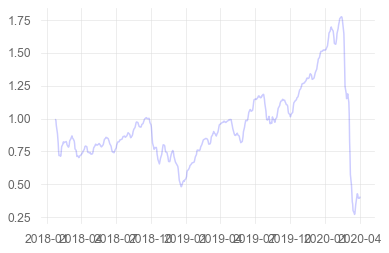

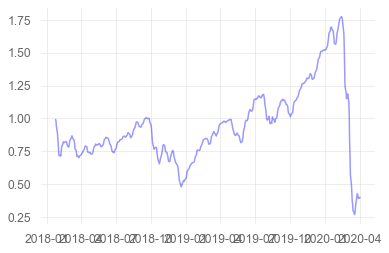

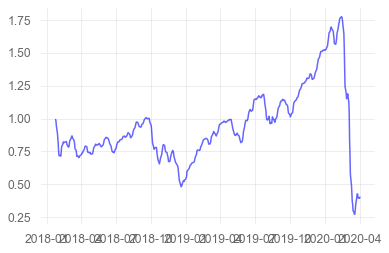

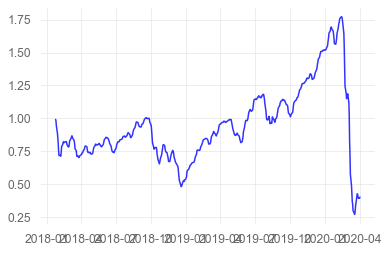

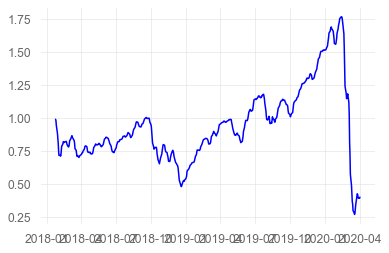

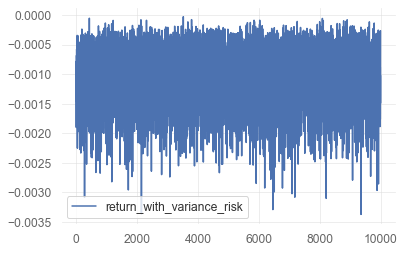

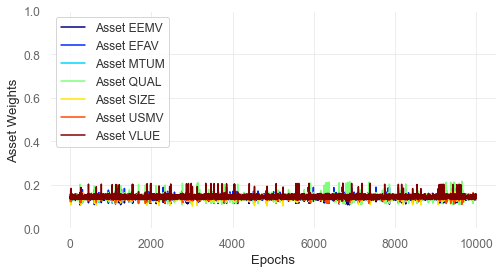

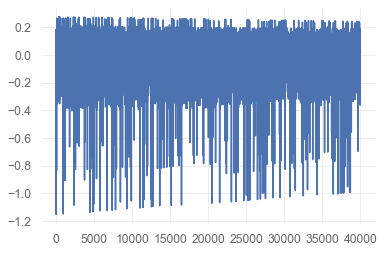

[]

In [18]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, verbose=True)

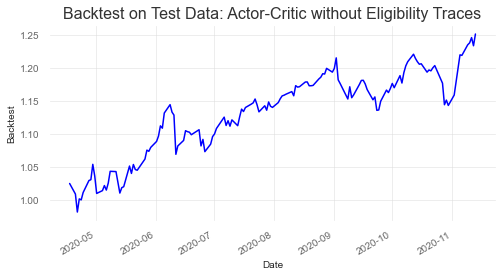

In [19]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')